In [33]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import constants
%matplotlib inline
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='arial', style='normal',
                                         size=24, weight='normal', stretch='normal')
from copy import deepcopy

In [34]:


class ternary_seg_profile:

    def __init__(self,
                D0_Co,Q_Co, # 1d array, same length as nd
                E_seg_Co,# 1d array, same length as nd
                D0_Cr,Q_Cr, # 1d array, same length as nd
                
                E_seg_Cr,# 1d array, same length as nd
                
                 
                c0_Co,c0_Cr,
                L_NiCr,L_NiCo,L_NiCrCo,L_CrCo,

                L_AlCr,
                L_AlCrNi,
                L_AlCrCo,
                L_NiCoAl,
                
                Lg_NiCo_Cr,
                Lg_NiCo_Al,
                Lg_Ni_AlCr,
                Lg_Co_AlCr,
                
                T,  # temperature
                d,  # layer distance
                nd, # number of layers
                dt,
                nt):

        """
        A class to calculate the segregation profiles as a function of time for a the CMSX-4 system.
        LongshengFeng's paper for Co-Cr co-segregation on the SISF. 
        The ternary system is represented as A-B-C, where A is solvent, B is solute #1, and C is solute #2.

        ...

        Attributes
        ----------
        D0_Cr and D0_Co: 1d array
            diffusion coefficients of solute B and C, have the same length as the number of layers $nd$
        Q_Cr and Q_Co : 1d array
            diffusion energy barriers of solute B and C, have the same length as the number of layers $nd$
        E_seg_Cr and E_seg_Co: 1d array
            segregation energies of solute B and C, have the same length as the number of layers $nd$
        c0_Co and c0_Cr: floats 
            initial solute concentrations between [0,1]
        L_NiCr,L_NiCo,L_NiCrCo, and L_CrCo: floats
            solute-solute interaction energies


        T: float
            temperature
        d: float
            inter-layer distance, unit in meter
        nd: int
            total number of layers 
        dt: float
            time increment to simulate the segregation process, unit in second
        nt: int
            number of time steps, nt*dt = total amount of time 
        Methods
        -------
        diffusivity(D0,Q,T):
            Calculate the diffusion coefficient given the diffusion data and temperature T.

        dX1_dt: 
            Calculate the concentration as a function of time. This is the main function to calculate the properties. 

        tabulate_calc_res:
            Start the calculation for dX1_dt and tabulate the results into a pandas.DataFrame

        """


        self.D0_Co = D0_Co
        self.Q_Co = Q_Co
        self.E_seg_Co = E_seg_Co
        self.D0_Cr = D0_Cr
        self.Q_Cr = Q_Cr

        self.E_seg_Cr = E_seg_Cr
        self.E_seg_Cr2 = deepcopy(E_seg_Cr)
        
        self.c0_Co = c0_Co
        self.c0_Ni = 0.75 - c0_Co
        self.c0_Cr = c0_Cr
        self.c0_Al = 0.25 - c0_Cr 
        self.L_NiCr = L_NiCr
        self.L_NiCo = L_NiCo
        self.L_NiCrCo = L_NiCrCo
        self.L_CrCo = L_CrCo
        
        self.L_AlCr = L_AlCr
        self.L_AlCrNi = L_AlCrNi
        self.L_AlCrCo = L_AlCrCo
        self.L_NiCoAl = L_NiCoAl
        self.Lg_NiCo_Cr = Lg_NiCo_Cr
        self.Lg_NiCo_Al = Lg_NiCo_Al
        self.Lg_Ni_AlCr = Lg_Ni_AlCr
        self.Lg_Co_AlCr = Lg_Co_AlCr

        self.T = T
        self.d = d
        self.nd = nd
        self.dt = dt
        self.nt = nt


    def diffusivity(self,D0,Q,T):
        # D0: m^2/s
        # Q: kJ/mole
        # RT: kJ/mole/K * K
        # T: Kelvin
        
        RT = constants.gas_constant *T/1000
        return D0*np.exp(-Q/RT)
        

    def dX1_dt(self):
        
        # E_seg: segregation energy for every layer in the system
        # Q: energy barrier for every layer in the system: jump from i+1 to i layer
        # A: solvent-A
        # B: solute-B
        # C: solute-C
        kBT = 8.617333262145e-5 * self.T #eV
        
        
        
        #print(Delta_G_ij)
        Eb_ji_Co = self.Q_Co
        Eb_ji_Cr = self.Q_Cr
        #print(Eb_ji)
        Dji_Co = self.diffusivity(self.D0_Co,Eb_ji_Co,self.T)# diffusion coefficient 
        Dji_Cr = self.diffusivity(self.D0_Cr,Eb_ji_Cr,self.T)# diffusion coefficient 
        #print(Dji)
        prefactor_Co = Dji_Co/self.d**4
        prefactor_Cr = Dji_Cr/self.d**4
        
        
        #print(exp_term_ij)
        # initial condition, all layers have the same concentrations
        X_layers_Co = np.zeros(self.nd)+self.c0_Co
        X_layers_Cr = np.zeros(self.nd)+self.c0_Cr
        #print(X_layers)
        X_layers_Co_vs_t = []
        X_layers_Co_vs_t.append(X_layers_Co)
        X_layers_Cr_vs_t = []
        X_layers_Cr_vs_t.append(X_layers_Cr)
        t = np.insert(np.cumsum(np.zeros(self.nt)+self.dt),0,0)
        excess_term_Co = np.zeros(self.nd)
        excess_term_Cr = np.zeros(self.nd)
        #t_all = 
        Delta_G_ij_Co_vs_t = []
        Delta_G_ij_Cr_vs_t = []
        # add excess term only to the first layer 
        
        # excess interaction terms
        X_layers_Ni = 0.75-X_layers_Co
        X_layers_Al = 0.25-X_layers_Cr
        A_term_Cr = self.L_AlCr + X_layers_Co*self.L_AlCrCo + X_layers_Ni*self.L_AlCrNi + 61/3*(X_layers_Co*self.Lg_Co_AlCr + X_layers_Ni*self.Lg_Ni_AlCr) 
        A_term_Cr0 = self.L_AlCr + self.c0_Co*self.L_AlCrCo + self.c0_Ni*self.L_AlCrNi + 61/3*(self.c0_Co*self.Lg_Co_AlCr + self.c0_Ni*self.Lg_Ni_AlCr) 
        
        A_term_Co = self.L_NiCo + X_layers_Cr*self.L_NiCrCo + X_layers_Al*self.L_NiCoAl + 55/9*(X_layers_Cr*self.Lg_NiCo_Cr + X_layers_Al*self.Lg_NiCo_Al)
        A_term_Co0 = self.L_NiCo + self.c0_Cr*self.L_NiCrCo + self.c0_Al*self.L_NiCoAl + 55/9*(self.c0_Cr*self.Lg_NiCo_Cr + self.c0_Al*self.Lg_NiCo_Al)
        
        #X_layers_Ni = 0.75-X_layers_Co
        #X_layers_Al = 0.25-X_layers_Cr
        mu_ex_Cr_x0 = (0.25-2*self.c0_Cr)*A_term_Cr0 
        mu_ex_Cr_x1 = (0.25-2*X_layers_Cr)*A_term_Cr 

        #
        mu_ex_Co_x0 = (0.75-2*self.c0_Co)*A_term_Co0 
        mu_ex_Co_x1 = (0.75-2*X_layers_Co)*A_term_Co 
        
        
        Delta_G_ij_Co_0 = np.array([self.E_seg_Co[i] - self.E_seg_Co[i+1] for i in range(len(self.E_seg_Co)-1) ] + [0] )
        cluster_fractions = X_layers_Co/0.75
        ##########################################################
        # This segregation energy assumes segregation of Cr near Co-clustering but no desegregation of Cr in the Co-lean
        self.E_seg_Cr = cluster_fractions*self.E_seg_Cr2 
        ##########################################################
        Delta_G_ij_Cr_0 = np.array([self.E_seg_Cr[i] - self.E_seg_Cr[i+1] for i in range(len(self.E_seg_Cr)-1) ] + [0] )
        
        non_zero_terms = Delta_G_ij_Cr_0.nonzero()
        for li in non_zero_terms:
            excess_term_Cr[li] = mu_ex_Cr_x1[li] - mu_ex_Cr_x0
            excess_term_Co[li] = mu_ex_Co_x1[li] - mu_ex_Co_x0
            
        Delta_excess_term_Cr = np.hstack([excess_term_Cr[:-1]-excess_term_Cr[1:],excess_term_Cr[-1]])
        Delta_excess_term_Co = np.hstack([excess_term_Co[:-1]-excess_term_Co[1:],excess_term_Co[-1]])
        
        Delta_G_ij_Co = Delta_G_ij_Co_0 + Delta_excess_term_Co
        Delta_G_ij_Cr = Delta_G_ij_Cr_0 + Delta_excess_term_Cr
        Delta_G_ij_Co_vs_t.append(Delta_G_ij_Co)
        Delta_G_ij_Cr_vs_t.append(Delta_G_ij_Cr)
        
        
        dX_layers_Co_vs_t = []
        dX_layers_Cr_vs_t = []
        for ti in range(self.nt):
            
            exp_term_ij_Co = np.exp(Delta_G_ij_Co/kBT)
            exp_term_ij_Cr = np.exp(Delta_G_ij_Cr/kBT)
            
            Wij_Co = np.array([0.75 - X_layers_Co[i+1] for i in range(len(X_layers_Co)-1) ] +[0.75-self.c0_Co])
            Wij_Cr = np.array([0.25 - X_layers_Cr[i+1] for i in range(len(X_layers_Cr)-1) ] +[0.25-self.c0_Cr])
            
            #print(Wij)
            Wji_Co = 0.75-X_layers_Co
            Wji_Cr = 0.25-X_layers_Cr
            #print(Wji)
            Xi_Co = np.array([x for x in X_layers_Co])
            Xi_Cr = np.array([x for x in X_layers_Cr])
            Xj_Co = np.array([X_layers_Co[i+1] for i in range(len(X_layers_Co)-1) ] +[self.c0_Co])
            Xj_Cr = np.array([X_layers_Cr[i+1] for i in range(len(X_layers_Cr)-1) ] +[self.c0_Cr])
            
            Jij_Co = prefactor_Co  * exp_term_ij_Co * Wij_Co * Xi_Co # out (right)
            Jji_Co = prefactor_Co  * Wji_Co * Xj_Co               # in  (left)
            
            Jij_Cr = prefactor_Cr  * exp_term_ij_Cr * Wij_Cr * Xi_Cr # out (right)
            Jji_Cr = prefactor_Cr  * Wji_Cr * Xj_Cr               # in  (left)
            
            #print(Jij)
            dX1dt_Co = [self.d**2 * (Jji_Co[0] - Jij_Co[0])]
            dX1dt_Cr = [self.d**2 * (Jji_Cr[0] - Jij_Cr[0])]
            
            dXidt_Co = [self.d**2 * (Jji_Co[i] + Jij_Co[i-1] - Jji_Co[i-1] - Jij_Co[i] ) for i in range(1,len(Jij_Co)-1) ]
            dXidt_Cr = [self.d**2 * (Jji_Cr[i] + Jij_Cr[i-1] - Jji_Cr[i-1] - Jij_Cr[i] ) for i in range(1,len(Jij_Cr)-1) ]
            
            dX_layers_Co = np.array(dX1dt_Co+dXidt_Co+[0])
            dX_layers_Cr = np.array(dX1dt_Cr+dXidt_Cr+[0])
            #print(len(dX_layers))
            #print(dX_layers)
            X_layers_Co = X_layers_Co + dX_layers_Co*self.dt
            X_layers_Cr = X_layers_Cr + dX_layers_Cr*self.dt
            dX_layers_Co_vs_t.append(dX_layers_Co*self.dt)
            dX_layers_Cr_vs_t.append(dX_layers_Cr*self.dt)
            
            X_layers_Co_vs_t.append(X_layers_Co)
            X_layers_Cr_vs_t.append(X_layers_Cr)
            
            # excess interaction terms
            X_layers_Ni = 0.75-X_layers_Co
            X_layers_Al = 0.25-X_layers_Cr
            
            A_term_Co = self.L_NiCo + X_layers_Cr*self.L_NiCrCo + X_layers_Al*self.L_NiCoAl + 55/9*(X_layers_Cr*self.Lg_NiCo_Cr + X_layers_Al*self.Lg_NiCo_Al)
            A_term_Co0 = self.L_NiCo + self.c0_Cr*self.L_NiCrCo + self.c0_Al*self.L_NiCoAl + 55/9*(self.c0_Cr*self.Lg_NiCo_Cr + self.c0_Al*self.Lg_NiCo_Al)
            
            A_term_Cr = self.L_AlCr + X_layers_Co*self.L_AlCrCo + X_layers_Ni*self.L_AlCrNi + 61/3*(X_layers_Co*self.Lg_Co_AlCr + X_layers_Ni*self.Lg_Ni_AlCr) 
            A_term_Cr0 = self.L_AlCr + self.c0_Co*self.L_AlCrCo + self.c0_Ni*self.L_AlCrNi + 61/3*(self.c0_Co*self.Lg_Co_AlCr + self.c0_Ni*self.Lg_Ni_AlCr) 
            
            
            mu_ex_Cr_x0 = (0.25-2*self.c0_Cr)*A_term_Cr0 
            mu_ex_Cr_x1 = (0.25-2*X_layers_Cr)*A_term_Cr 

            #
            mu_ex_Co_x0 = (0.75-2*self.c0_Co)*A_term_Co0 
            mu_ex_Co_x1 = (0.75-2*X_layers_Co)*A_term_Co 

            self.E_seg_Cr = cluster_fractions*self.E_seg_Cr2 #+ (1-cluster_fractions)*self.E_seg_Cr1 
            Delta_G_ij_Cr_0 = np.array([self.E_seg_Cr[i] - self.E_seg_Cr[i+1] for i in range(len(self.E_seg_Cr)-1) ] + [0] )
            non_zero_terms = Delta_G_ij_Cr_0.nonzero()
            
            for li in non_zero_terms:
                excess_term_Cr[li] = mu_ex_Cr_x1[li] - mu_ex_Cr_x0
                excess_term_Co[li] = mu_ex_Co_x1[li] - mu_ex_Co_x0

            Delta_excess_term_Cr = np.hstack([excess_term_Cr[:-1]-excess_term_Cr[1:],excess_term_Cr[-1]])
            Delta_excess_term_Co = np.hstack([excess_term_Co[:-1]-excess_term_Co[1:],excess_term_Co[-1]])
            
            
            Delta_G_ij_Co = Delta_G_ij_Co_0 + Delta_excess_term_Co
            Delta_G_ij_Cr = Delta_G_ij_Cr_0 + Delta_excess_term_Cr
            Delta_G_ij_Co_vs_t.append(Delta_G_ij_Co)
            Delta_G_ij_Cr_vs_t.append(Delta_G_ij_Cr)
            
        return np.array(X_layers_Co_vs_t),np.array(X_layers_Cr_vs_t),np.array(Delta_G_ij_Co_vs_t),np.array(Delta_G_ij_Cr_vs_t),np.array(dX_layers_Co_vs_t),np.array(dX_layers_Cr_vs_t),t


    def tabulate_calc_res(self):
        
        X_layers_Co_vs_t,X_layers_Cr_vs_t,Delta_G_ij_Co_vs_t,Delta_G_ij_Cr_vs_t,dX_layers_Co_vs_t,dX_layers_Cr_vs_t,t = self.dX1_dt()
        
        
        
        self.X_layers_Co_vs_t = X_layers_Co_vs_t
        self.X_layers_Cr_vs_t = X_layers_Cr_vs_t
        self.Delta_G_ij_Co_vs_t = Delta_G_ij_Co_vs_t
        self.Delta_G_ij_Cr_vs_t = Delta_G_ij_Cr_vs_t
        self.dX_layers_Co_vs_t = dX_layers_Co_vs_t
        self.dX_layers_Cr_vs_t = dX_layers_Cr_vs_t
        
        self.t = t

        self.calc_data = pd.DataFrame()


        self.calc_data['time(s)'] = self.t
        
        for i in range(self.nd):
            self.calc_data[f'x_Cr_layer_{i}'] = self.X_layers_Cr_vs_t.T[i]

        for i in range(self.nd):
            self.calc_data[f'x_Co_layer_{i}'] = self.X_layers_Co_vs_t.T[i]




In [35]:
# Grid and time step parameters
data_Ni = pd.read_json('../data/Ni_221_flip_E.json')
# 
b = 2.5e-10 #m
a = np.sqrt(2)*b
d = a/np.sqrt(3)
d = b
nd = 100

# segregation parameters
T = 1023 #K

# C: Co

c0_Co = 0.066

D0_Co = 6.616e-07 #m^2/s
Q_Co = 224.09 #kJ/mol

E_seg_list_Co = np.zeros(nd)
E_seg_list_Co[0] = -0.0165#data_Ni['Co'][0]
E_seg_list_Co[1] = 0#data_Ni['Co'][1]
E_seg_list_Co[2] = 0#data_Ni['Co'][2]
E_seg_list_Co[3] = 0#data_Ni['Co'][3]
E_seg_list_Co[4] = 0#data_Ni['Co'][4]


Q_list_Co = np.random.normal(loc=Q_Co,scale=5,size=nd)

# B: Cr
c0_Cr = 0.022

D0_Cr = 0.001821 #m^2/s
Q_Cr = 307.99 #kJ/mol


E_seg_list_Cr2 = np.zeros(nd)


E_seg_list_Cr2[0] = (-420/1000)  
E_seg_list_Cr2[1] = (-397/1000)  
E_seg_list_Cr2[2] = (-141/1000)  
E_seg_list_Cr2[3] = (0/1000)#(78/1000)  
E_seg_list_Cr2[4] = (0/1000) 

#E_seg_list_Cr2[0] =  (-566/1000) 
#E_seg_list_Cr2[1] =  (-503/1000) 
#E_seg_list_Cr2[2] =  (-179/1000) 
#E_seg_list_Cr2[3] =  (+89/1000) 
#E_seg_list_Cr2[4] =  (18/1000) 


Q_list_Cr = np.random.normal(loc=Q_Cr,scale=5,size=nd)


# time
dt = 0.015  # time step size /s
nt = 20000  # number of time steps


In [36]:
# solute-solute interaction energies
J2eV = 8.617333262145e-5/1.380649e-23
NA = constants.Avogadro

# data from https://doi.org/10.1016/j.calphad.2015.12.007
# Cr in Ni # FCC
L_NiCr = (+8030-12.8801*T) * J2eV /NA

# Co in Ni # FCC
L_NiCo = (-800+1.2629*T) * J2eV /NA

# Co-Cr in Ni # FCC
L_NiCrCo = (-40710+13.5334*T) * J2eV /NA

# Co-Cr
L_CrCo = (+1500-9.592*T) * J2eV/NA  # value used in Liu's calphad paper
#L_CrCo = (-24052.09+8.1884*T) * J2eV/NA # another value available in Liu's thesis from another reference


# Al-Cr
L_AlCr = (-45900+6*T) * J2eV/NA
# Al-Cr-Ni
L_AlCrNi = 30300 * J2eV/NA
# Al-Co-Cr
L_AlCrCo = (+989.5+8.277709*T)*J2eV/NA
# Al-Co-Ni
L_NiCoAl = 0

######################################################################
# gamma prime
Lg_AlCr = 0 * J2eV / NA # value used in Liu's calphad paper
#Lg_AlCr = -830 * J2eV / NA # value not confirmed? 
U_CoCr = U_CrCo = 0 # value used in Liu's calphad paper
#U_CoCr = U_CrCo = (-5616+9.250*T) * J2eV/NA # another value available in Liu's thesis: -5616+9.250*T
#########################
U_CoNi = U_NiCo = 0
U_CoAl = U_AlCo = -4872 * J2eV / NA
#########################

U_NiCr = U_CrNi = -1980 *J2eV/NA

UALNI = (-22212.8931+4.39570389*T) 
TROIS = 3
UNTIER = TROIS**(-1)
U_NiAl = U_AlNi = 2*UNTIER*UALNI * J2eV/NA

#A_term_Co = self.L_NiCo + X_layers_Cr*self.L_NiCrCo + X_layers_Al*self.L_NiCoAl + 55/9*(X_layers_Cr*self.Lg_NiCo_Cr + X_layers_Al*self.Lg_NiCo_Al)

a_Ni3Cr = 0
a_Co3Cr = 0

a_Ni3Al = 0
a_Co3Al = 0

G_Ni3Cr = (3*U_NiCr+3*a_Ni3Cr)
G_Co3Cr = (3*U_CoCr+3*a_Co3Cr)
G_Ni3Al = (3*U_NiAl+3*a_Ni3Al)
G_Co3Al = (3*U_CoAl+3*a_Co3Al)

a_CoNi2Cr = 0
a_Co2NiCr = 0 
a_CoNi2Al = 0
a_Co2NiAl = 0

G_CoNi2Cr = 2*U_CoNi + 2*U_CoCr + U_NiCr + a_CoNi2Cr
G_Co2NiCr = 2*U_CoNi + 2*U_CoCr + U_NiCr + a_Co2NiCr

G_CoNi2Al = 2*U_CoNi + 2*U_CoAl + U_NiAl + a_CoNi2Al
G_Co2NiAl = 2*U_CoNi + 2*U_CoAl + U_NiAl + a_Co2NiAl

Lg_NiCo_Cr = -3/2*G_Ni3Cr - 3/2*G_Co3Cr + 3/2*G_CoNi2Cr + 3/2*G_Co2NiCr
Lg_NiCo_Al = -3/2*G_Ni3Al - 3/2*G_Co3Al + 3/2*G_CoNi2Al + 3/2*G_Co2NiAl

Lg_Ni_AlCr = Lg_Co_AlCr = Lg_AlCr


In [37]:
system = ternary_seg_profile(D0_Co,Q_Co, # 1d array, same length as nd
                E_seg_list_Co,# 1d array, same length as nd
                D0_Cr,Q_Cr, # 1d array, same length as nd
                
                E_seg_list_Cr2, 
                
                             
                c0_Co,c0_Cr,
                             
                L_NiCr,
                L_NiCo,
                L_NiCrCo,
                L_CrCo,

                L_AlCr,
                L_AlCrNi,
                L_AlCrCo,
                L_NiCoAl,
                             
                Lg_NiCo_Cr,
                Lg_NiCo_Al,
                             
                Lg_Ni_AlCr,
                Lg_Co_AlCr,
                
                T,  # temperature
                d,  # layer distance
                nd, # number of layers
                dt,
                nt)


In [38]:
system.diffusivity(system.D0_Co,system.Q_Co,system.T)


2.3918092949888722e-18

In [39]:
system.diffusivity(system.D0_Cr,system.Q_Cr,system.T)

3.4242803918193867e-19

In [40]:
system.tabulate_calc_res()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:302: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


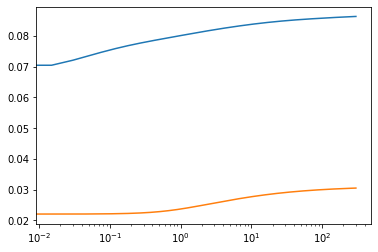

In [42]:
plt.plot(system.calc_data['time(s)'],system.calc_data['x_Co_layer_0'])
plt.plot(system.calc_data['time(s)'],system.calc_data['x_Cr_layer_0'])
plt.xscale('log')
#plt.plot(system.calc_data['time(s)'],system.calc_data['x_Cr_layer_0'])

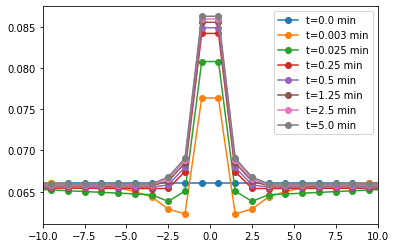

In [43]:
for i in [0,10,100,1000,2000,5000,10000,20000]:
    X_of_layers = np.hstack([system.X_layers_Co_vs_t[i][::-1],system.X_layers_Co_vs_t[i]])
    
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    plt.plot(n_layers,X_of_layers,'-o',
             label=f't={np.round(system.t[i]/60,3)} min')
    
plt.xlim(-10,10)
plt.legend()


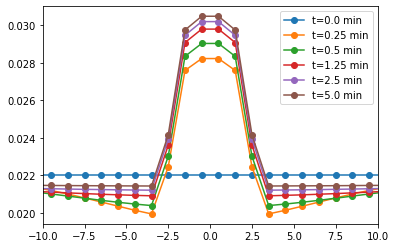

In [44]:
for i in [0,1000,2000,5000,10000,20000]:
    X_of_layers = np.hstack([system.X_layers_Cr_vs_t[i][::-1],system.X_layers_Cr_vs_t[i]])
    layers = np.arange(nd)+0.5

    n_layers = np.hstack([-layers[::-1],layers])
    plt.plot(n_layers,X_of_layers,'-o',
             label=f't={np.round(system.t[i]/60,3)} min')

plt.xlim(-10,10)
#plt.ylim(0.015,0.032)
plt.legend()


<Figure size 432x288 with 0 Axes>

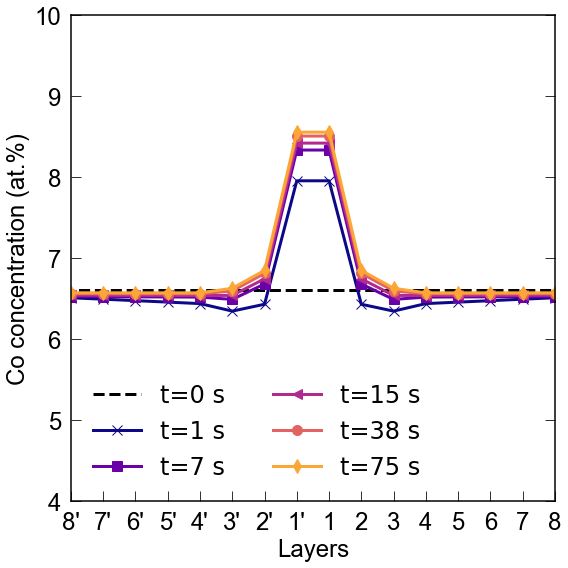

In [47]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(-7.5,7.5)
ax1.set_ylim(4,10)

def generate_gradient_colors(num_colors=10):
    # Create a gradient from one color to another
    colors = plt.cm.plasma(np.linspace(0, 1, num_colors))
    return colors

CB_color_cycle = generate_gradient_colors(num_colors=6)
                  
markers = ['x','s','<','o','d','>','v']

m_i = 0

for i in [0]:
    X_of_layers = np.hstack([system.X_layers_Co_vs_t[i][::-1],system.X_layers_Co_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    
    ax1.plot(n_layers,X_of_layers,ls='--',lw=3,color='k',
             label=f't={int(np.ceil(t[i]))} s')
    #m_i +=1 
    
    
for i in [50,500,1000,2500,5000]:
    X_of_layers = np.hstack([system.X_layers_Co_vs_t[i][::-1],system.X_layers_Co_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    
    ax1.plot(n_layers,X_of_layers,marker=markers[m_i],color=CB_color_cycle[m_i],lw=3,markersize=10,
             label=f't={int(np.round(t[i]))} s')
    m_i +=1 
ax1.set_xticks([x+0.5 for x in np.arange(-8,8)])
labellist = [x for x in range(1,9)]

ax1.set_xticklabels([str(x)+'\'' for x in labellist[::-1]]+labellist,fontsize=24)

ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_xlabel('Layers',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,ncol=2)
ax1.set_ylabel('Co concentration (at.%)',fontproperties=ticks_font)
plt.tight_layout()
#f.savefig('./plots/NiCoCr_ISF_Co_seg_vs_layers.pdf')

<Figure size 432x288 with 0 Axes>

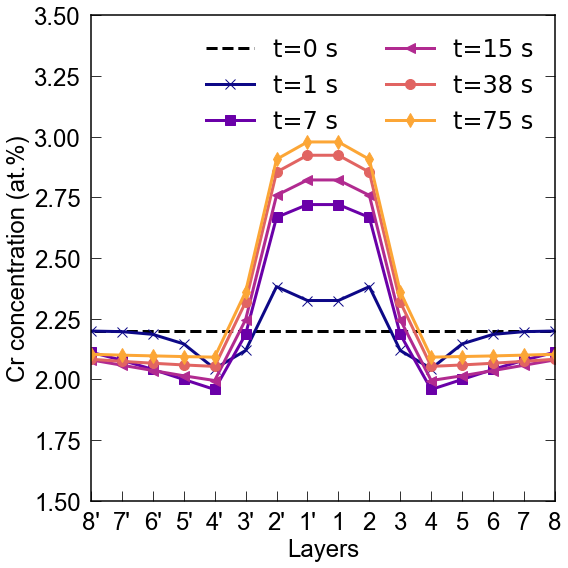

In [48]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(-7.5,7.5)
ax1.set_ylim(1.5,3.5)

def generate_gradient_colors(num_colors=10):
    # Create a gradient from one color to another
    colors = plt.cm.plasma(np.linspace(0, 1, num_colors))
    return colors

CB_color_cycle = generate_gradient_colors(num_colors=6)
                  
markers = ['x','s','<','o','d','>','v']

m_i = 0

for i in [0]:
    X_of_layers = np.hstack([system.X_layers_Cr_vs_t[i][::-1],system.X_layers_Cr_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    
    ax1.plot(n_layers,X_of_layers,ls='--',lw=3,color='k',
             label=f't={int(np.ceil(t[i]))} s')
    #m_i +=1 
    
    
for i in [50,500,1000,2500,5000]:
    X_of_layers = np.hstack([system.X_layers_Cr_vs_t[i][::-1],system.X_layers_Cr_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    
    ax1.plot(n_layers,X_of_layers,marker=markers[m_i],color=CB_color_cycle[m_i],lw=3,markersize=10,
             label=f't={int(np.round(t[i]))} s')
    m_i +=1 
ax1.set_xticks([x+0.5 for x in np.arange(-8,8)])
labellist = [x for x in range(1,9)]

ax1.set_xticklabels([str(x)+'\'' for x in labellist[::-1]]+labellist,fontsize=24)

ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_xlabel('Layers',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,ncol=2)
ax1.set_ylabel('Cr concentration (at.%)',fontproperties=ticks_font)
plt.tight_layout()
#f.savefig('./plots/NiCoCr_ISF_Cr_seg_vs_layers.pdf')


In [49]:
exp_data_Co = pd.read_csv('./exp_data/CMSX4_Co.csv')
exp_data_Cr = pd.read_csv('./exp_data/CMSX4_Cr.csv')

<Figure size 432x288 with 0 Axes>

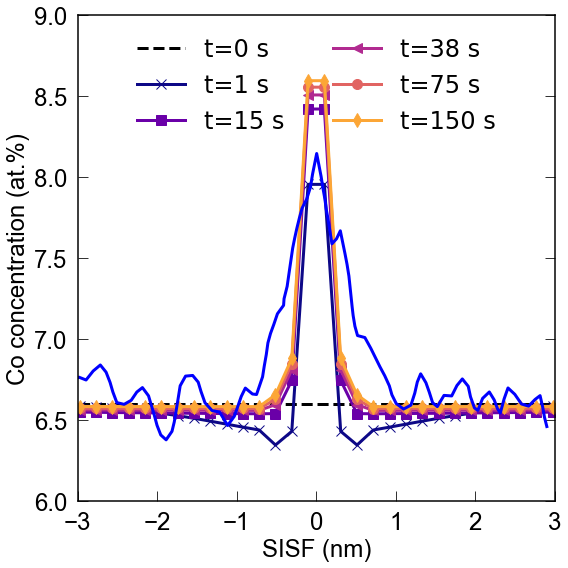

In [50]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(-3,3)
ax1.set_ylim(6.,9)

def generate_gradient_colors(num_colors=10):
    # Create a gradient from one color to another
    colors = plt.cm.plasma(np.linspace(0, 1, num_colors))
    return colors

CB_color_cycle = generate_gradient_colors(num_colors=6)
                  
markers = ['x','s','<','o','d','>','v']



m_i = 0

for i in [0]:
    X_of_layers = np.hstack([system.X_layers_Co_vs_t[i][::-1],system.X_layers_Co_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])
    
    ax1.plot(n_layers,X_of_layers,ls='--',lw=3,color='k',
             label=f't={int(np.ceil(t[i]))} s')
    #m_i +=1 
    
    
for i in [50,1000,2500,5000,10000]:
    X_of_layers = np.hstack([system.X_layers_Co_vs_t[i][::-1],system.X_layers_Co_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])*0.205
    
    ax1.plot(n_layers,X_of_layers,marker=markers[m_i],color=CB_color_cycle[m_i],lw=3,markersize=10,
             label=f't={int(np.round(t[i]))} s')
    m_i +=1 

ax1.plot(exp_data_Co.x-0.1,exp_data_Co.y,ls='-',lw=3,color='b',)    
#ax1.set_xticks([x+0.5 for x in np.arange(-8,8)])



#labellist = [x for x in range(1,9)]

#ax1.set_xticklabels([str(x)+'\'' for x in labellist[::-1]]+labellist,fontsize=24)

ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_xlabel('SISF (nm)',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,ncol=2,loc='upper center')
ax1.set_ylabel('Co concentration (at.%)',fontproperties=ticks_font)
plt.tight_layout()
#f.savefig('./plots/CMSX4_SISF_Co_seg_vs_layers.pdf')

<Figure size 432x288 with 0 Axes>

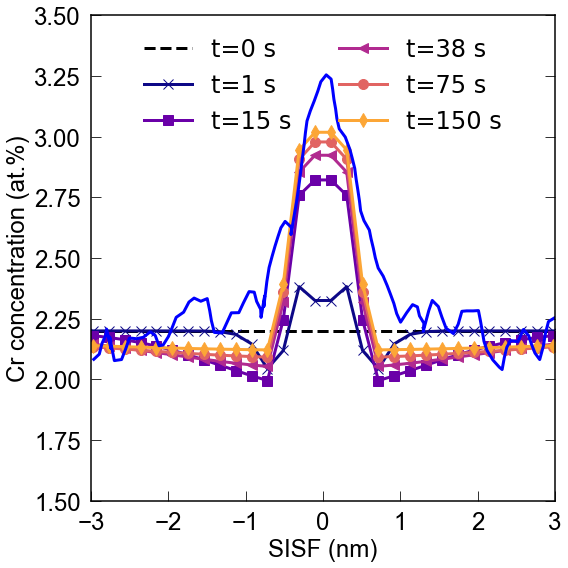

In [51]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(-3,3)
ax1.set_ylim(1.5,3.5)

def generate_gradient_colors(num_colors=10):
    # Create a gradient from one color to another
    colors = plt.cm.plasma(np.linspace(0, 1, num_colors))
    return colors

CB_color_cycle = generate_gradient_colors(num_colors=6)
                  
markers = ['x','s','<','o','d','>','v']

m_i = 0

for i in [0]:
    X_of_layers = np.hstack([system.X_layers_Cr_vs_t[i][::-1],system.X_layers_Cr_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])*0.205
    
    ax1.plot(n_layers,X_of_layers,ls='--',lw=3,color='k',
             label=f't={int(np.ceil(t[i]))} s')
    #m_i +=1 
    
    
for i in [50,1000,2500,5000,10000]:
    X_of_layers = np.hstack([system.X_layers_Cr_vs_t[i][::-1],system.X_layers_Cr_vs_t[i]])*100
    layers = np.arange(nd)+0.5
    
    n_layers = np.hstack([-layers[::-1],layers])*0.205
    
    ax1.plot(n_layers,X_of_layers,marker=markers[m_i],color=CB_color_cycle[m_i],lw=3,markersize=10,
             label=f't={int(np.round(t[i]))} s')
    m_i +=1 
    
    
ax1.plot(exp_data_Cr.x,exp_data_Cr.y,ls='-',lw=3,color='b')    
#ax1.set_xticks([x+0.5 for x in np.arange(-8,8)])
#labellist = [x for x in range(1,9)]

#ax1.set_xticklabels([str(x)+'\'' for x in labellist[::-1]]+labellist,fontsize=24)

ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_xlabel('SISF (nm)',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,ncol=2,loc='upper center')
ax1.set_ylabel('Cr concentration (at.%)',fontproperties=ticks_font)
plt.tight_layout()
#f.savefig('./plots/CMSX4_SISF_Cr_seg_vs_layers.pdf')


<Figure size 432x288 with 0 Axes>

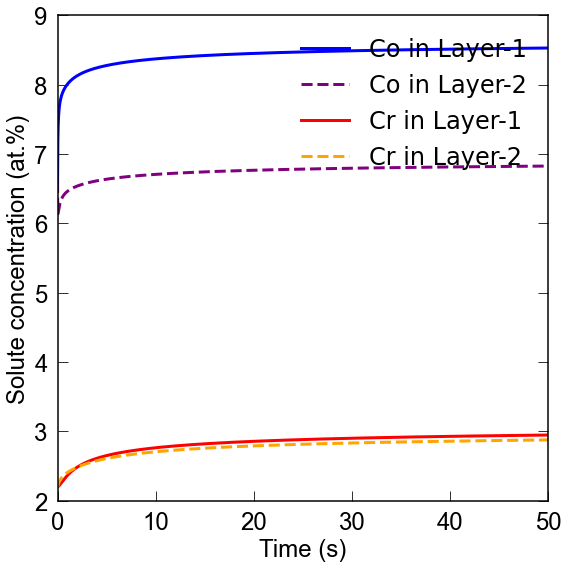

In [52]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(0.0,50)
ax1.set_ylim(2,9)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','k']
                  
markers = ['o','<','s','d','x','>','v']

ax1.plot(t,system.X_layers_Co_vs_t.T[0]*100,
         color='b',mec='b',mfc='None',ls='-',lw=3,label='Co in Layer-1')

ax1.plot(t,system.X_layers_Co_vs_t.T[1]*100,
         color='purple',mec='b',mfc='None',ls='--',lw=3,label='Co in Layer-2')


ax1.plot(t,system.X_layers_Cr_vs_t.T[0]*100,
         color='r',mec='r',mfc='None',ls='-',lw=3,label='Cr in Layer-1')

ax1.plot(t,system.X_layers_Cr_vs_t.T[1]*100,
         color='orange',mec='r',mfc='None',ls='--',lw=3,label='Cr in Layer-2')






ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_ylabel('Solute concentration (at.%)',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,loc='upper right')
ax1.set_xlabel('Time (s)',fontproperties=ticks_font)
plt.tight_layout()

#f.savefig('./plots/CMSX4_ISF_layer_time.pdf')

<Figure size 432x288 with 0 Axes>

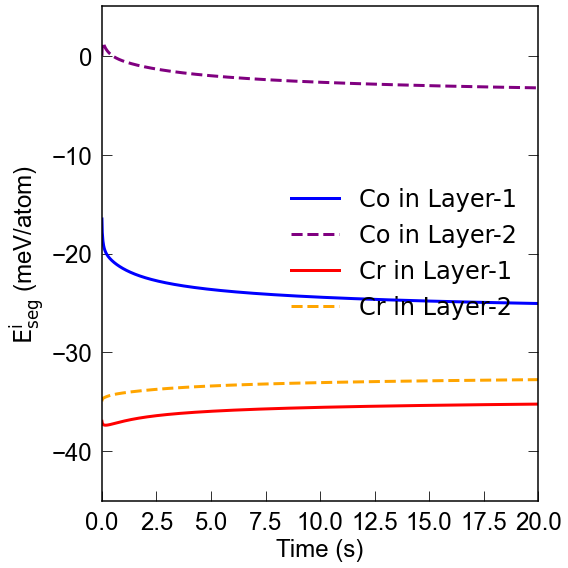

In [53]:
plt.draw()
f = plt.figure(figsize=(8,8))

(ax1) = f.subplots(1,1)
[i.set_linewidth(1.5) for i in ax1.spines.values()]

ax1.set_xlim(0.0,20)
ax1.set_ylim(-45,5)
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00','k']
                  
markers = ['o','<','s','d','x','>','v']


Seg_Energy_B_L_1 = system.Delta_G_ij_Cr_vs_t.T[0] + system.Delta_G_ij_Cr_vs_t.T[1]+system.Delta_G_ij_Cr_vs_t.T[2]+system.Delta_G_ij_Cr_vs_t.T[3]+system.Delta_G_ij_Cr_vs_t.T[4]

Seg_Energy_B_L_2 = system.Delta_G_ij_Cr_vs_t.T[1]+system.Delta_G_ij_Cr_vs_t.T[2]+system.Delta_G_ij_Cr_vs_t.T[3]+system.Delta_G_ij_Cr_vs_t.T[4]
            
Seg_Energy_C_L_1 = system.Delta_G_ij_Co_vs_t.T[0] + system.Delta_G_ij_Co_vs_t.T[1]+system.Delta_G_ij_Co_vs_t.T[2]+system.Delta_G_ij_Co_vs_t.T[3]+system.Delta_G_ij_Co_vs_t.T[4]

Seg_Energy_C_L_2 = system.Delta_G_ij_Co_vs_t.T[1]+system.Delta_G_ij_Co_vs_t.T[2]+system.Delta_G_ij_Co_vs_t.T[3]+system.Delta_G_ij_Co_vs_t.T[4]


t = system.calc_data['time(s)']

ax1.plot(t,Seg_Energy_C_L_1*1000,
         color='b',mec='b',mfc='None',ls='-',lw=3,label='Co in Layer-1')

ax1.plot(t,Seg_Energy_C_L_2*1000,
         color='purple',mec='b',mfc='None',ls='--',lw=3,label='Co in Layer-2')

ax1.plot(t,Seg_Energy_B_L_1*1000,
         color='r',mec='r',mfc='None',ls='-',lw=3,label='Cr in Layer-1')

ax1.plot(t,Seg_Energy_B_L_2*1000,
         color='orange',mec='m',mfc='None',ls='--',lw=3,label='Cr in Layer-2')


#ax1.plot(t,Seg_Energy_B_L_2*1000,
#         color='r',mec='r',mfc='None',ls='--',lw=3,label='Cr in Ni-5Co-5Cr Layer-2')


#overall_comp = np.array([np.mean(x) for x in X_layers_vs_t])*100
#ax1.plot(t,overall_comp,color='k',mec='k',mfc='None',ls='--',lw=3,label='Averaged')


ax1.tick_params(direction='in',axis='both',length=10,right=True,pad=10)
for labelx1 in (ax1.get_xticklabels()):
    labelx1.set_fontproperties(ticks_font)
    
for labely1 in (ax1.get_yticklabels()):
    labely1.set_fontproperties(ticks_font)
    
ax1.set_ylabel('$\mathsf{E_{seg}^i}$ (meV/atom)',fontproperties=ticks_font)
ax1.legend(fontsize=24,frameon=False,loc='center right')
ax1.set_xlabel('Time (s)',fontproperties=ticks_font)
plt.tight_layout()

#f.savefig('./plots/CMSX4_ISF_layer_i_Seg_energy_time.pdf')